INDE 535, American University of Beirut

Code written by: Ahmad Shmayssani, Jad Atweh , Nour Mouaness

In [61]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [62]:
def load_data(filename):
    """
    Load data from a CSV file into a DataFrame.

    Parameters:
    filename (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The loaded data in a DataFrame.
    """
    dataset = pd.read_csv(filename)
    X = dataset.iloc[:, :]
    return X

In [63]:
def time_to_seconds(X):
    """
    Convert datetime columns to seconds for consistent measurement.

    Parameters:
    X (pd.DataFrame): The input DataFrame.

    Returns:
    pd.Series: The converted time columns in seconds.
    """
    return (
        (X.second)
        + (X.minute * 60)
        + (X.hour * 3600)
        + (X.day * 24 * 3600)
        + (X.month * 24 * 3600 * 31)
        + (X.year * 24 * 3600 * 30 * 365)
    )

In [64]:
def clean_data(X):
    """
    Clean the data by dropping irrelevant columns and rows with missing data.

    Parameters:
    X (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    pd.Series: The target variable.
    """
    X = X.drop(["traffic_source"], axis=1)
    X = X[X["country"].notna()]
    X = X[X["device_type"].notna()]

    y = X["contact"]

    X = X.loc[
        ~((X["total_visits"] >= 2) & (X["previous_session_start_time"].isnull()))
    ].reset_index(drop=True)

    X = X.reset_index()

    X[
        [
            "display_time",
            "previous_session_start_time",
            "current_session_start_time",
            "first_session_start_time",
            "previous_display_time",
        ]
    ] = X[
        [
            "display_time",
            "previous_session_start_time",
            "current_session_start_time",
            "first_session_start_time",
            "previous_display_time",
        ]
    ].apply(
        pd.to_datetime
    )

    return X, y

In [65]:
def drop_inconsistencies(X):
    """
    Drop rows with inconsistencies in the data.

    Parameters:
    X (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The DataFrame without inconsistencies.
    pd.Series: The target variable.
    """
    drop = list()
    for i in range(X.shape[0]):
        if X["previous_displays_this_session"][i] > 0:
            if (
                time_to_seconds(X["display_time"][i])
                - time_to_seconds(X["previous_display_time"][i])
                < 0
            ):
                drop.append(i)
        if X["total_visits"][i] >= 2:
            if (
                time_to_seconds(X["current_session_start_time"][i])
                - time_to_seconds(X["previous_session_start_time"][i])
                < 0
            ):
                drop.append(i)

    X = X.drop(X.index[drop]).reset_index(drop=True)
    y = X["contact"]

    return X, y

In [66]:
def process_data(X):
    """
    Process time-related features into numerical variables.

    Parameters:
    X (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with processed time-related features.
    """
    try1, try2 = list(), list()  # for mean approximation

    Time_to_display_actual, Time_between_visits_actual, Time_between_displays = (
        list(),
        list(),
        list(),
    )

    for i in range(X["display_time"].shape[0]):
        if X["total_visits"][i] >= 2:
            try1.append(
                (
                    time_to_seconds(X["current_session_start_time"][i])
                    - time_to_seconds(X["previous_session_start_time"][i])
                )
            )

        if X["previous_displays_this_session"][i] != 0:
            try2.append(
                (
                    (
                        time_to_seconds(X["display_time"][i])
                        - time_to_seconds(X["previous_display_time"][i])
                    )
                )
            )

    mean1 = np.mean(try1)
    mean2 = np.mean(try2)

    for i in range(X["display_time"].shape[0]):
        Time_to_display_actual.append(
            (time_to_seconds(X["display_time"][i]))
            - (time_to_seconds(X["current_session_start_time"][i]))
        )

        if X["total_visits"][i] >= 2:
            Time_between_visits_actual.append(
                (
                    time_to_seconds(X["current_session_start_time"][i])
                    - time_to_seconds(X["previous_session_start_time"][i])
                )
            )

        else:
            Time_between_visits_actual.append(mean1)

        if X["previous_displays_this_session"][i] != 0:
            Time_between_displays.append(
                (
                    (
                        time_to_seconds(X["display_time"][i])
                        - time_to_seconds(X["previous_display_time"][i])
                    )
                )
            )

        else:
            Time_between_displays.append(mean2)

    X.insert(1, "Time_to_display_actual", Time_to_display_actual)
    X.insert(1, "Time_between_visits_actual", Time_between_visits_actual)
    X.insert(1, "Time_between_displays", Time_between_displays)
    return X

In [67]:
def drop_columns(X):
    """
    Drops specific columns from the input DataFrame 'X'.

    Parameters:
    X (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with specified columns dropped.
    """
    columns_to_drop = [
        "index",
        "uid",
        "row_id",
        "display_time",
        "previous_session_start_time",
        "first_session_start_time",
        "current_session_start_time",
        "previous_display_time",
        "contact",
    ]

    X = X.drop(columns=columns_to_drop, axis=1)
    return X

In [68]:
def transform_data(X):
    """
    Transform categorical features into numerical using Label Encoding.

    Parameters:
    X (pd.DataFrame): The input DataFrame containing categorical columns.

    Returns:
    pd.DataFrame: The DataFrame with categorical columns transformed into numerical.
    """
    le = LabelEncoder()  # Ordinal Encoding

    # Encode each categorical column using LabelEncoder
    X["landing_page"] = le.fit_transform(X["landing_page"])
    X["current_url"] = le.fit_transform(X["current_url"])
    X["call_center_status"] = le.fit_transform(X["call_center_status"])
    X["display_reason"] = le.fit_transform(X["display_reason"])
    X["response_promise"] = le.fit_transform(X["response_promise"])
    X["country"] = le.fit_transform(X["country"])
    X["message_type"] = le.fit_transform(X["message_type"])
    X["device_type"] = le.fit_transform(X["device_type"])

    return X

In [69]:
def balance_data(X, y):
    """
    Balance the data using SMOTE.

    Parameters:
    X (pd.DataFrame): The input DataFrame.
    y (pd.Series): The target variable.

    Returns:
    pd.DataFrame: The balanced DataFrame.
    pd.Series: The balanced target variable.
    """
    # Encode non-numeric columns in X if needed
    non_numeric_cols = X.select_dtypes(include=["object"]).columns
    for col in non_numeric_cols:
        X[col] = LabelEncoder().fit_transform(X[col])

    smote = SMOTE(sampling_strategy="minority")
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [70]:
def mean_norm(X):
    """
    Perform mean normalization on the input data to mean 0 and std 1

    Parameters:
    X (array-like or pd.DataFrame): The input data to be mean-normalized.

    Returns:
    array-like: The mean-normalized data.
    """
    # Fit the StandardScaler to calculate mean and standard deviation
    scaler = preprocessing.StandardScaler().fit(X)

    # Transform the input data to perform mean normalization
    X_normalized = scaler.transform(X)

    return X_normalized

In [71]:
def split_data(X, y):
    """
    Split the data into training and testing sets.

    Parameters:
    X (pd.DataFrame): The input DataFrame.
    y (pd.Series): The target variable.

    Returns:
    pd.DataFrame: The training data.
    pd.Series: The training target variable.
    pd.DataFrame: The testing data.
    pd.Series: The testing target variable.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    return X_train, y_train, X_test, y_test

In [72]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model using accuracy and confusion matrix.

    Parameters:
    model: The trained machine learning model.
    X_test (pd.DataFrame): The testing data.
    y_test (pd.Series): The testing target variable.
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n{cm}")

In [73]:
def visualize_data(X, y):
    """
    Perform descriptive statistics and visualizations on the dataset.

    Parameters:
    - X: DataFrame containing the dataset.
    - y: Series containing target labels.

    This function calculates various statistics and creates visualizations to provide insights into the dataset.
    """

    # Label encode 'uid' column
    X["uid"] = LabelEncoder().fit_transform(X["uid"])

    # Number of Customers
    n_customers = max(X["uid"]) + 1

    # Conversion Rate of Customers
    conversion_rate_customers = ((len(y[y == 1])) / n_customers) * 100
    print("Conversion Rate of Customers:", conversion_rate_customers)

    # Create a DataFrame for 'contact' entries
    contact_dataframe = X[X["contact"] == 1]

    # Calculate the mean and standard deviation of 'Number_of_Displays_to_accept'
    table = contact_dataframe.pivot_table(
        index="uid",
        values=["previous_displays_this_session", "contact"],
        aggfunc={"previous_displays_this_session": np.sum, "contact": np.sum},
    )
    table["Number_of_Displays_to_accept"] = [
        (table["previous_displays_this_session"]
         [index]) / (table["contact"][index])
        for index, row in table.iterrows()
    ]
    mean_number_of_displays_to_accept = table["Number_of_Displays_to_accept"].mean(
    )
    stdev_number_of_displays_to_accept = table["Number_of_Displays_to_accept"].std(
    )

    print("Mean number of displays:", mean_number_of_displays_to_accept)
    print(
        "Standard deviation for number of displays:", stdev_number_of_displays_to_accept
    )

    # Create pie chart for device type
    data = contact_dataframe.groupby("device_type")["contact"].sum()
    labels = ["desktop", "mobile", "tablet"]
    pie, ax = plt.subplots(figsize=[10, 6])
    plt.pie(x=data, autopct="%.1f%%", labels=labels, pctdistance=0.5)
    plt.title("Device Type Effect on Offer Acceptance", fontsize=14)
    plt.show()

    # Create bar chart for response promise
    contact_dataframe["response_promise"] = contact_dataframe[
        "response_promise"
    ].astype(str)
    data_per = (
        contact_dataframe.groupby("response_promise")
        .agg(percentage=("contact", lambda p: p.sum() / data.sum() * 100))
        .round(2)
    )
    labels = ["1 minute", "ASAP", "Later Today", "Other"]
    sns.set_style("whitegrid")
    bar, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(
        x=labels,
        y="percentage",
        data=data_per,
        errorbar=None,
        palette="muted",
        orient="v",
    )

    ax.set_title(
        "Bar Chart to see Effect of Response Promise on Contact Offer Acceptance",
        fontsize=15,
    )
    ax.set_xlabel("Response Promise")
    ax.set_ylabel("Percentage")
    for rect in ax.patches:
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            rect.get_height(),
            "%.1f%%" % rect.get_height(),
            weight="bold",
        )
    plt.show()

    # Create bar chart for display reason
    data_per = (
        contact_dataframe.groupby("display_reason")
        .agg(percentage=("contact", lambda p: p.sum() / data.sum() * 100))
        .round(2)
    )
    labels = ["id" + str(i) for i in range(1, 6)]
    sns.set_style("whitegrid")
    bar, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(
        x=labels,
        y="percentage",
        data=data_per,
        errorbar=None,
        palette="muted",
        orient="v",
    )
    ax.set_title(
        "Bar Chart to see Effect of Display Reason on Contact Offer Acceptance",
        fontsize=15,
    )
    ax.set_xlabel("Display Reason")
    ax.set_ylabel("Percentage")
    for rect in ax.patches:
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            rect.get_height(),
            "%.1f%%" % rect.get_height(),
            weight="bold",
        )
    plt.show()

    # Create histogram for Time To Display Offer
    plt.hist(
        contact_dataframe["Time_to_display_actual"],
        bins=10,
        range=[0, 1000],
        density=False,
        edgecolor="black",
    )
    plt.xlabel("Time To Display Offer")
    plt.ylabel("Frequency")
    plt.show()

    # Create histogram for Total Visits
    plt.hist(
        contact_dataframe["total_visits"],
        bins=10,
        range=[0, 20],
        density=False,
        edgecolor="black",
    )
    plt.xlabel("Total Visits")
    plt.ylabel("Frequency")
    plt.show()

    # Create count plot for country
    count = contact_dataframe.groupby("country").agg(
        percentage=("contact", lambda p: p.sum().round(2))
    )
    sns.countplot(x="country", hue="contact",
                  data=contact_dataframe, palette="Set2")
    plt.show()

    return

In [74]:
from sklearn.linear_model import LogisticRegression


def train_and_evaluate_logistic_regression(X_train, y_train, X_test, y_test):
    """
    Train a Logistic Regression model on the training data and evaluate it on the test data.

    Parameters:
    X_train (pd.DataFrame): The features of the training data.
    y_train (pd.Series): The target variable of the training data.
    X_test (pd.DataFrame): The features of the test data.
    y_test (pd.Series): The target variable of the test data.

    Returns:
    None
    """
    # Create a Logistic Regression model
    model = LogisticRegression()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Evaluate the Logistic Regression model on the test data
    evaluate_model(model, X_test, y_test)

In [75]:
from sklearn.neighbors import KNeighborsClassifier


def train_and_evaluate_knn(X_train, y_train, X_test, y_test, n_neighbors=3):
    """
    Train a K-Nearest Neighbors (KNN) classifier on the training data and evaluate it on the test data.

    Parameters:
    X_train (pd.DataFrame): The features of the training data.
    y_train (pd.Series): The target variable of the training data.
    X_test (pd.DataFrame): The features of the test data.
    y_test (pd.Series): The target variable of the test data.
    n_neighbors (int): The number of neighbors to consider (default is 3).

    Returns:
    None
    """
    # Create a K-Nearest Neighbors (KNN) classifier
    model = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Evaluate the K-Nearest Neighbors (KNN) model on the test data
    evaluate_model(model, X_test, y_test)

In [76]:
from sklearn.ensemble import RandomForestClassifier


def train_and_evaluate_random_forest(X_train, y_train, X_test, y_test, random_state=42):
    """
    Train a Random Forest classifier on the training data and evaluate it on the test data.

    Parameters:
    X_train (pd.DataFrame): The features of the training data.
    y_train (pd.Series): The target variable of the training data.
    X_test (pd.DataFrame): The features of the test data.
    y_test (pd.Series): The target variable of the test data.
    random_state (int): Random seed for reproducibility (default is 42).

    Returns:
    None
    """
    # Create a Random Forest classifier
    model = RandomForestClassifier(random_state=random_state)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Evaluate the Random Forest model on the test data
    evaluate_model(model, X_test, y_test)

In [77]:
from sklearn.neural_network import MLPClassifier


def train_and_evaluate_mlp(
    X_train,
    y_train,
    X_test,
    y_test,
    hidden_layer_sizes=(30, 30),
    solver="lbfgs",
    activation="logistic",
):
    """
    Train an MLP classifier on the training data and evaluate it on the test data.

    Parameters:
    X_train (pd.DataFrame): The features of the training data.
    y_train (pd.Series): The target variable of the training data.
    X_test (pd.DataFrame): The features of the test data.
    y_test (pd.Series): The target variable of the test data.
    hidden_layer_sizes (tuple): The sizes of the hidden layers in the MLP (default is (30, 30)).
    solver (str): The solver for weight optimization (default is 'lbfgs').
    activation (str): The activation function for the hidden layers (default is 'logistic').

    Returns:
    None
    """
    # Create an MLP classifier with the specified conditions
    model = MLPClassifier(
        solver=solver, hidden_layer_sizes=hidden_layer_sizes, activation=activation
    )

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Evaluate the MLP model on the test data
    evaluate_model(model, X_test, y_test)

Conversion Rate of Customers: 3.321936795416744
Mean number of displays: 0.6501160092807424
Standard deviation for number of displays: 1.3512648417481887


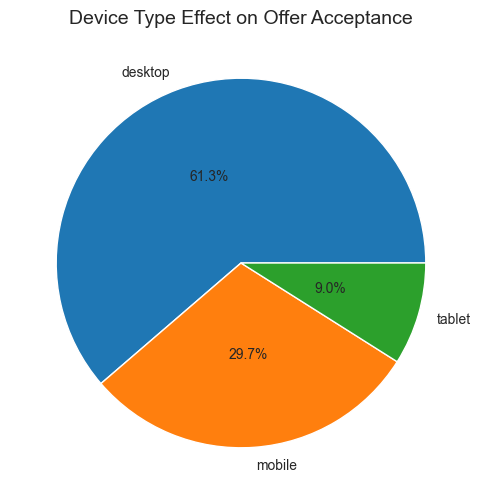

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_24728\2955154524.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contact_dataframe["response_promise"] = contact_dataframe[


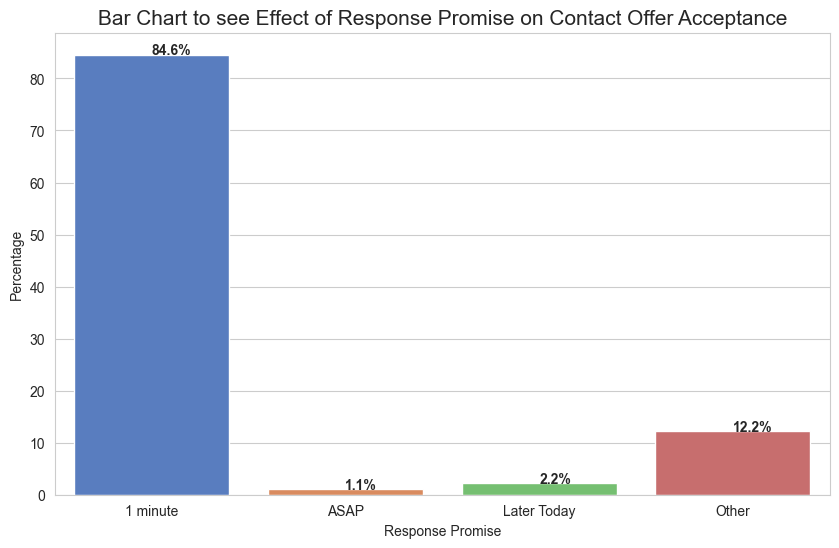

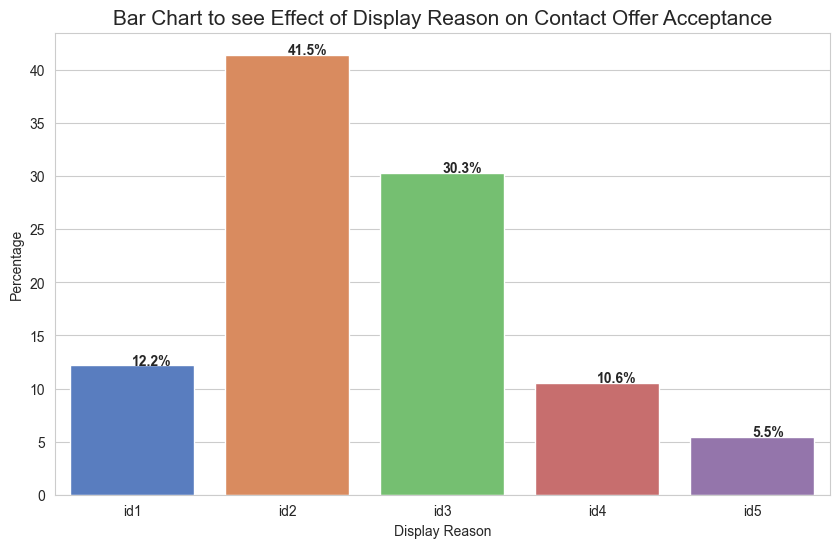

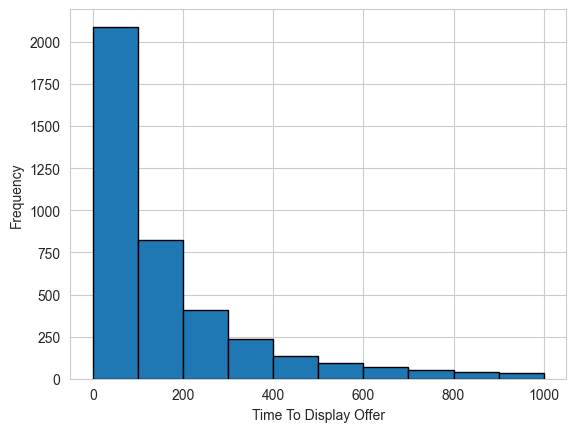

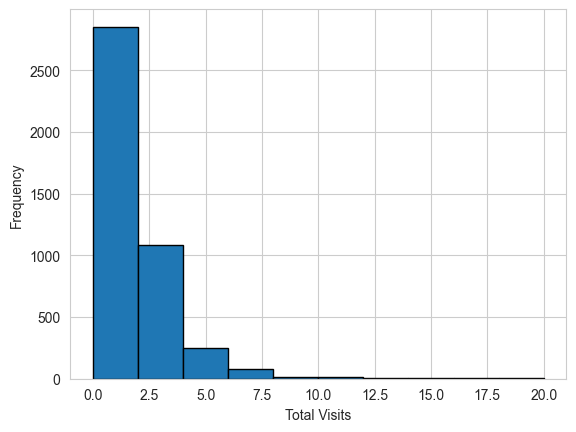

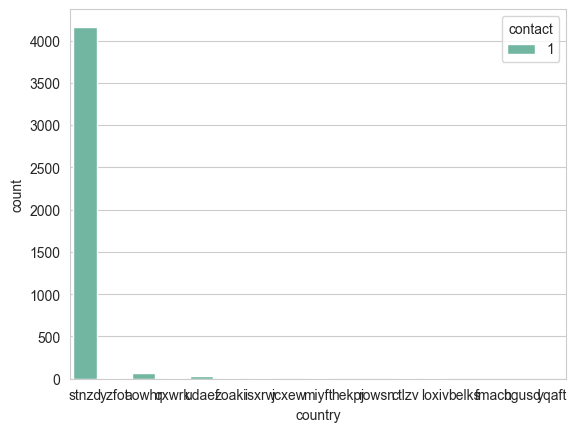

Accuracy: 0.649586282524175
Confusion Matrix:
[[26833 18327]
 [13308 31811]]


In [78]:
def main():
    # Load data
    data = load_data("data.csv")

    # Clean data
    data, target = clean_data(data)

    # Drop inconsistencies
    data, target = drop_inconsistencies(data)

    # Process data
    data = process_data(data)

    # Visualize data
    visualize_data(data, target)

    # Drop columns
    data = drop_columns(data)

    # Transform string data to labels
    data = transform_data(data)

    # Balance data via upsampling
    data, target = balance_data(data, target)

    # Normalize data
    data = mean_norm(data)

    # Split data
    X_train, y_train, X_test, y_test = split_data(data, target)

    # Train and evaluate a machine learning model
    train_and_evaluate_logistic_regression(X_train, y_train, X_test, y_test)


if __name__ == "__main__":
    main()

*In our project, we conducted an extensive analysis of various machine learning algorithms to address a specific problem using our dataset. We explored MLP, Neural Networks, and Random Forest, with each algorithm offering its own advantages. However, when it came to a trade-off between performance and computational resources, Logistic Regression consistently emerged as the top performer in terms of both accuracy and training speed.*

*While MLP showed exceptional performance, it demanded significant computational power, making it less practical for our specific project. Logistic Regression, on the other hand, demonstrated remarkable efficiency and effectiveness. Its simplicity and quick training times allowed us to iterate through model development and testing swiftly. Moreover, Logistic Regression achieved higher accuracy in predicting our target variable compared to other algorithms, making it the preferred choice for our dataset given the trade-offs involved.*